In [78]:
import json

from modeling import get_order, Runner
from plotnine import *

In [46]:
from sklearn.datasets import load_wine
wine = load_wine(as_frame = True).frame
wine["target2"] = (wine.target==1).astype(int).astype(int)
wine.loc[:,"row_id"] = wine.index

In [80]:
with open('class_config.json', 'r') as config_file:
    config = json.load(config_file)

order = get_order(df = wine, config = config)

runner = Runner(workers = 4)
runner.run(order = order)

process started
adding result
adding result
adding result
adding result
adding result
adding result


In [ ]:
runner._futures[0].exception()

In [85]:
evaldf = pd.DataFrame(order.get_results()['eval'])
evaldf.head()

,task_id,param_id,split_id,sklearn:precision_score,num_boost_round,objective,eval_metric,eta,max_depth
0,3,0,1,0.546667,1000,reg:logistic,error,0.3,4
0,3,0,1,0.546667,500,reg:logistic,error,0.3,4
0,0,0,0,0.310811,1000,reg:logistic,error,0.3,4
0,0,0,0,0.310811,500,reg:logistic,error,0.3,4
0,2,2,0,0.310811,1000,reg:logistic,error,0.3,8


In [94]:
predictions = pd.DataFrame(order.get_results()['predictions'])
predictions.head()

,row_id,predictions,truth,num_boost_round,objective,eval_metric,eta,max_depth,task_id,param_id,split_id
0,89,0.990234,1,1000,reg:logistic,error,0.3,4,3,0,1
1,90,0.979258,1,1000,reg:logistic,error,0.3,4,3,0,1
2,91,0.987462,1,1000,reg:logistic,error,0.3,4,3,0,1
3,92,0.990234,1,1000,reg:logistic,error,0.3,4,3,0,1
4,93,0.962167,1,1000,reg:logistic,error,0.3,4,3,0,1


In [83]:
def plot_cv_plot(df, metric_name):
    display = df.copy()
    display.loc[:, 'split_id'] = display.split_id.astype(str)
    p1 = (ggplot(display, aes(x = 'param_id', y = metric_name, color = 'split_id'))
          + geom_point(size = 3)
          + theme_minimal()
          + labs(title = metric_name)
         )
    return p1

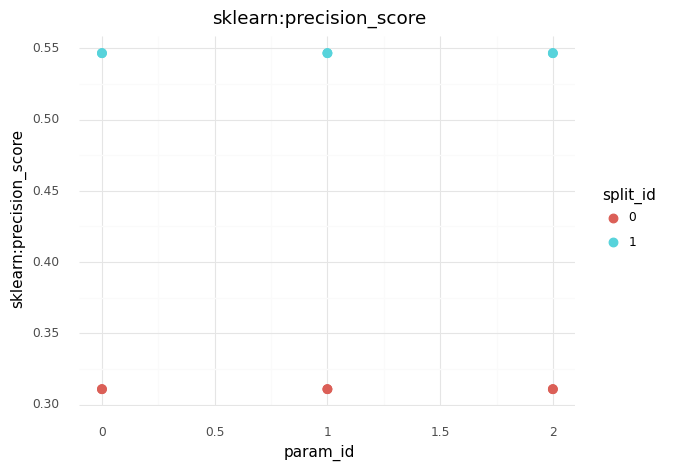

In [86]:
for metric in config['validation']['evalulation']['metrics']:
    print(plot_cv_plot(df = evaldf, metric_name = metric))

## Hosted as a web service

In [ ]:
import requests
request = f'http://0.0.0.0:5050/train/job1'
r = requests.post(request,
                  json = {"config": reg_config,
                          "df": wine.to_dict()})
r.text

In [ ]:
t = {'key': 1}
', '.join(list(t.keys()))

In [ ]:
request = f'http://0.0.0.0:5050/train/test1'
r = requests.get(request)
r.json()